In [55]:
import numpy as np
import pandas as pd
import io
import os
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


## Explore Data

In [3]:
data_dir = '/kaggle/input/satellite-image-classification/data'
labels = os.listdir(data_dir)
labels

['cloudy', 'desert', 'green_area', 'water']

Found 5631 files belonging to 4 classes.


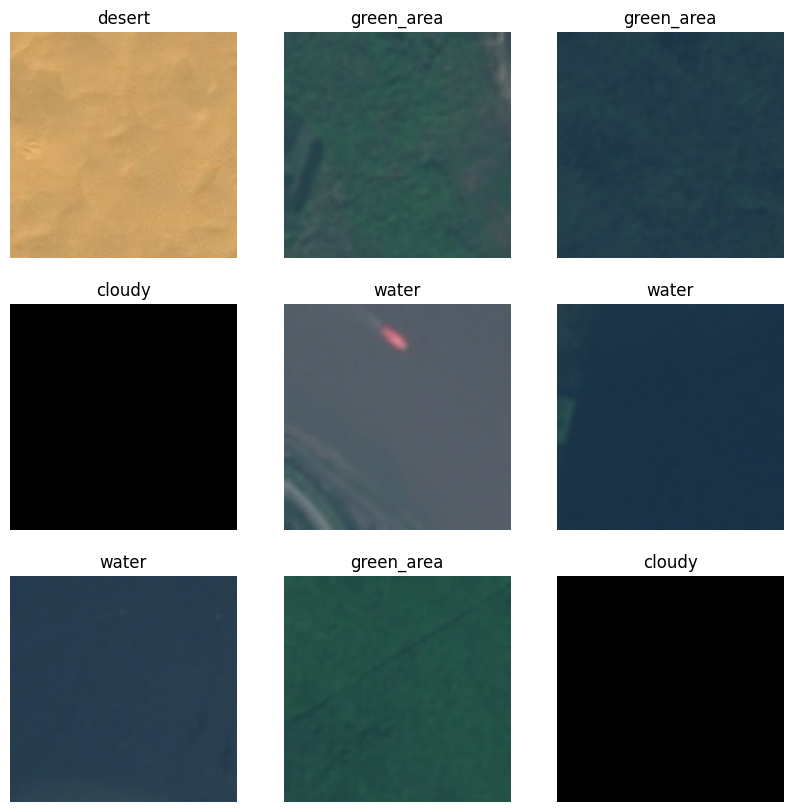

In [4]:

train_dataset = image_dataset_from_directory('../input/satellite-image-classification/data',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [5]:
img_width, img_height = 224, 224
target_size = (img_width,img_height)
batch_size = 32

In [6]:
#Create a data generator for image augmentation
datagen = ImageDataGenerator( samplewise_center=True,  # set each sample mean to 0
                             rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1, # Randomly zoom imag
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False,
                             rescale=1./255,#scale images
                             validation_split=0.2) #split data, 80% for training and 20% for testing


#create training set from folders
train_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       shuffle=True,subset='training')

#create test set
test_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                      class_mode='categorical',
                                       shuffle=False,subset='validation')

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


## Evaluation Functions 

In [13]:
def learning_curves(history):
    #plot the result
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot
    plt.plot(epochs, acc, color='green', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()
    #loss plot
    plt.plot(epochs, loss, color='pink', label='Training Loss')
    plt.plot(epochs, val_loss, color='red', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [14]:
def get_predections(model):
    # Generate predictions on the test set
    y_pred = model.predict(test_data)

    # Compute the confusion matrix
    y_true = test_data.classes
    y_pred = tf.argmax(y_pred, axis=1)
    return y_true,y_pred
    
def show_confusion_matrix(y_true,y_pred):
    cm  = confusion_matrix(y_pred,y_true)
    df_cm = pd.DataFrame(cm, index =   ["cloud","desert" ,'green_area', 'water'],
                  columns = ["cloud","desert" ,'green_area', 'water'])

    seaborn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
    plt.title('confusion matrix')
    plt.ylabel('prediction')
    plt.xlabel('Actual')
    plt.show()
    
def print_classification_report(y_true,y_pred):
    target_names = ["cloud","desert" ,'green_area', 'water']
    print(classification_report(y_true, y_pred, target_names=target_names))

## VGG19 based model

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg_base_model =  VGG19(include_top=True , weights='imagenet')
for layer in vgg_base_model.layers:
    layer.trainable= False

Load the vgg19 model from keras

In [ ]:
vgg_base_model = tf.keras.Model(inputs=vgg_base_model.input, outputs=vgg_base_model.layers[-2].output)
vgg_model = tf.keras.Sequential()
for layer in vgg_base_model.layers:
    vgg_model.add(layer)

vgg_model.add(tf.keras.layers.Dense(4, activation='softmax'))

copy vgg layers and add top layer

In [ ]:
vgg_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)


In [ ]:
vgg_history = vgg_model.fit(train_data,
    validation_data = test_data, 
    callbacks = [early],
    epochs = 50)

In [ ]:
vgg_model.evaluate(test_data)


## MobileNet

### 1 layer

In [46]:
mobile_base_model = tf.keras.applications.MobileNet()
for layer in mobile_base_model.layers:
    layer.trainable= False

### 3 layers

In [24]:
mobile_base_model = tf.keras.applications.MobileNet()
for layer in mobile_base_model.layers[:-3]:
    layer.trainable= False

### 5 layers

In [56]:
mobile_base_model = tf.keras.applications.MobileNet()
for layer in mobile_base_model.layers[:-5]:
    layer.trainable= False

#### model build

In [57]:
mobile_base_model = tf.keras.Model(inputs=mobile_base_model.input, outputs=mobile_base_model.layers[-2].output)

mobile_model = tf.keras.Sequential()

for layer in mobile_base_model.layers:
    mobile_model.add(layer)
    
mobile_model.add(tf.keras.layers.Dense(4, activation='softmax'))

#### Adam optimizer

In [58]:
mobile_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [62]:
mobile_history = mobile_model.fit(train_data,
    validation_data = test_data, 
#     callbacks = [early],
    epochs = 40)

Epoch 1/40
141/141 [==============================] - 61s 434ms/step - loss: 0.0577 - accuracy: 0.9845 - val_loss: 0.1018 - val_accuracy: 0.9813
Epoch 2/40
141/141 [==============================] - 62s 439ms/step - loss: 0.0501 - accuracy: 0.9869 - val_loss: 0.0786 - val_accuracy: 0.9769
Epoch 3/40
141/141 [==============================] - 62s 438ms/step - loss: 0.0651 - accuracy: 0.9831 - val_loss: 0.1160 - val_accuracy: 0.9742
Epoch 4/40
141/141 [==============================] - 64s 451ms/step - loss: 0.0332 - accuracy: 0.9913 - val_loss: 0.0849 - val_accuracy: 0.9840
Epoch 5/40
141/141 [==============================] - 63s 445ms/step - loss: 0.0566 - accuracy: 0.9880 - val_loss: 0.0485 - val_accuracy: 0.9902
Epoch 6/40
141/141 [==============================] - 62s 437ms/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 0.0486 - val_accuracy: 0.9876
Epoch 7/40
141/141 [==============================] - 61s 435ms/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0453 - val_ac

In [63]:
mobile_model.evaluate(test_data)

36/36 [==============================] - 12s 344ms/step - loss: 0.0572 - accuracy: 0.9929


[0.057214368134737015, 0.9928951859474182]

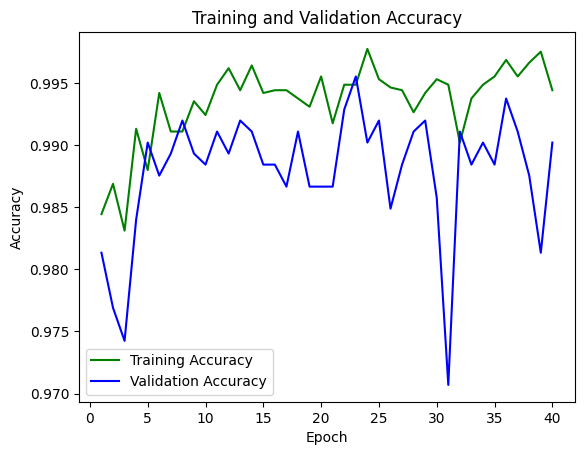

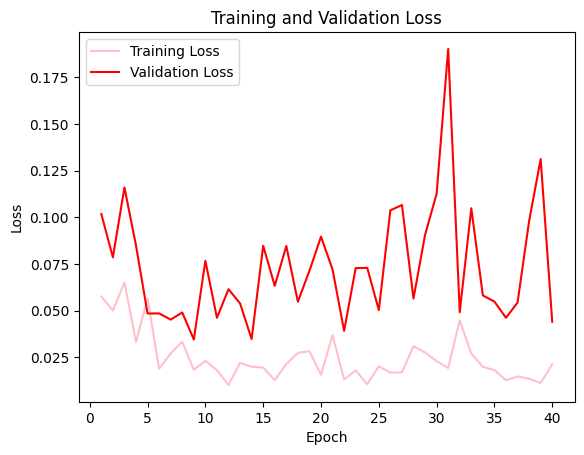

In [64]:
learning_curves(mobile_history)

36/36 [==============================] - 13s 341ms/step


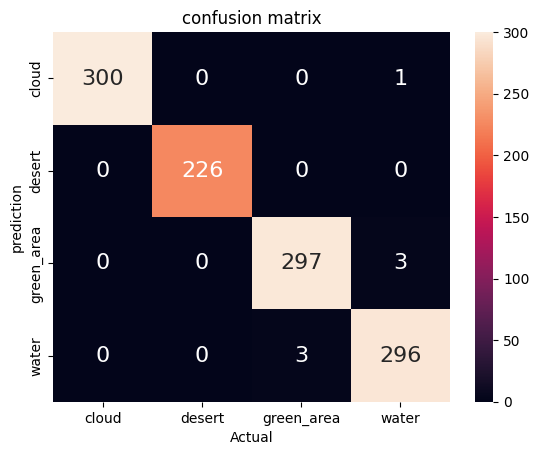

In [65]:
y_true,y_pred = get_predections(mobile_model)
show_confusion_matrix(y_true,y_pred)

In [66]:
print_classification_report(y_true,y_pred)

              precision    recall  f1-score   support

       cloud       1.00      1.00      1.00       300
      desert       1.00      1.00      1.00       226
  green_area       0.99      0.99      0.99       300
       water       0.99      0.99      0.99       300

    accuracy                           0.99      1126
   macro avg       0.99      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126



#### SGD optimizer

In [67]:
mobile_model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [68]:
mobile_history = mobile_model.fit(train_data,
    validation_data = test_data, 
#     callbacks = [early],
    epochs = 40)

Epoch 1/40


2023-12-30 21:19:29.605576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 65s 447ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0649 - val_accuracy: 0.9902
Epoch 2/40
141/141 [==============================] - 62s 440ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0733 - val_accuracy: 0.9902
Epoch 3/40
141/141 [==============================] - 61s 433ms/step - loss: 0.0098 - accuracy: 0.9973 - val_loss: 0.0894 - val_accuracy: 0.9911
Epoch 4/40
141/141 [==============================] - 62s 437ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 0.0553 - val_accuracy: 0.9956
Epoch 5/40
141/141 [==============================] - 62s 443ms/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.0548 - val_accuracy: 0.9947
Epoch 6/40
141/141 [==============================] - 62s 439ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0681 - val_accuracy: 0.9902
Epoch 7/40
141/141 [==============================] - 61s 435ms/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.0585 - val_accuracy: 0.9

In [69]:
mobile_model.evaluate(test_data)

36/36 [==============================] - 13s 355ms/step - loss: 0.0389 - accuracy: 0.9947


[0.038887377828359604, 0.9946714043617249]

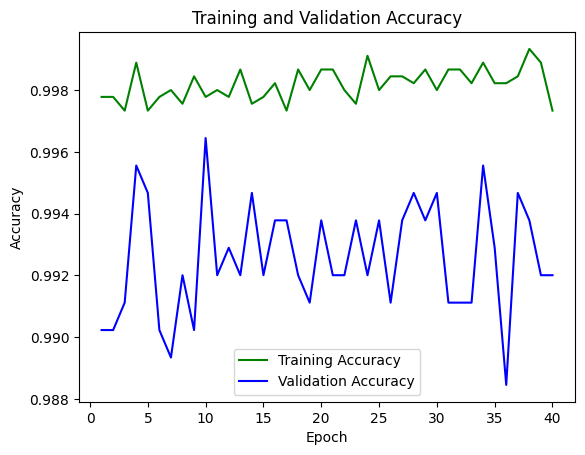

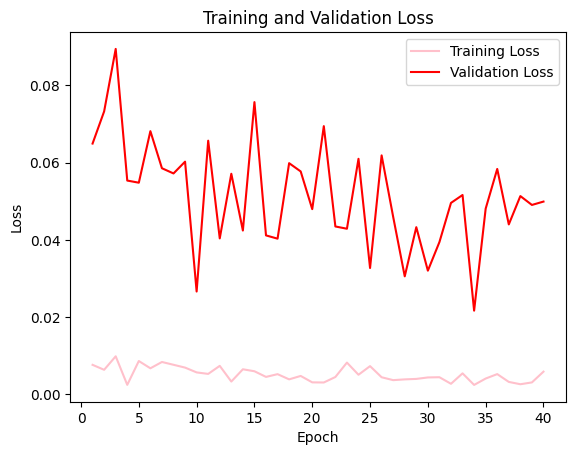

In [70]:
learning_curves(mobile_history)

36/36 [==============================] - 13s 341ms/step


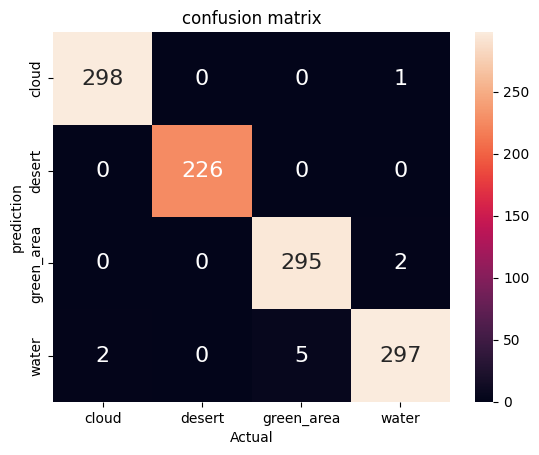

In [71]:
y_true,y_pred = get_predections(mobile_model)
show_confusion_matrix(y_true,y_pred)

In [72]:
print_classification_report(y_true,y_pred)

              precision    recall  f1-score   support

       cloud       1.00      0.99      0.99       300
      desert       1.00      1.00      1.00       226
  green_area       0.99      0.98      0.99       300
       water       0.98      0.99      0.98       300

    accuracy                           0.99      1126
   macro avg       0.99      0.99      0.99      1126
weighted avg       0.99      0.99      0.99      1126



## ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

#Create a data generator for image augmentation
datagen = ImageDataGenerator( preprocessing_function=preprocess_input,
                             samplewise_center=True,  # set each sample mean to 0
                             rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1, # Randomly zoom imag
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False,
                             rescale=1./255,#scale images
                             validation_split=0.2) #split data, 80% for training and 20% for testing


#create training set from folders
train_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       shuffle=True,subset='training')

#create test set
test_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                      class_mode='categorical',
                                       shuffle=False,subset='validation')

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet_base_model = ResNet50(weights='imagenet', include_top=True)

for layer in resnet_base_model.layers:
    layer.trainable = False

In [ ]:
x = resnet_base_model(resnet_base_model.input)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

resnet_model = tf.keras.Model(inputs=resnet_base_model.input, outputs=outputs)

In [ ]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
resnet_history = resnet_model.fit(train_data,
    validation_data = test_data, 
    callbacks = [early],
    epochs = 50)

In [ ]:
resnet_model.evaluate(test_data)

## Traditional Model

In [ ]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(244, 244, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
      train_data,
      validation_data = test_data, 
      epochs=50)

In [ ]:
model.evaluate(test_data, steps=50)